In [12]:
# Library imports
import os
import random
import itertools
import numpy as np
import pandas as pd
import tsfel
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Import data from MakeDataset
from Dataset.MakeDataset import X_train, X_test, y_train, y_test

# Configure matplotlib for inline plotting
%matplotlib inline
%config InlineBackend.figure_format = "retina"


## 1. Plot the waveform for one sample data from each activity class. Are you able to see any difference/similarities between the activities? You can plot a subplot having 6 columns to show differences/similarities between the activities. Do you think the model will be able to classify the activities based on the data?

In [13]:
# Give the path of the test and train folder of UCI HAR Dataset
dataset_path = "./UCI HAR Dataset"
train_path = "./UCI HAR Dataset/train"
test_path = "./UCI HAR Dataset/test"

# Dictionary of activities. Provided by the dataset.
ACTIVITIES = {
    1: 'WALKING'            ,
    2: 'WALKING_UPSTAIRS'   ,
    3: 'WALKING_DOWNSTAIRS' ,
    4: 'SITTING'            ,
    5: 'STANDING'           ,
    6: 'LAYING'             ,
}

# Compute total acceleration
total_acc = np.sqrt(X_train[..., 0]**2 + X_train[..., 1]**2 + X_train[..., 2]**2)

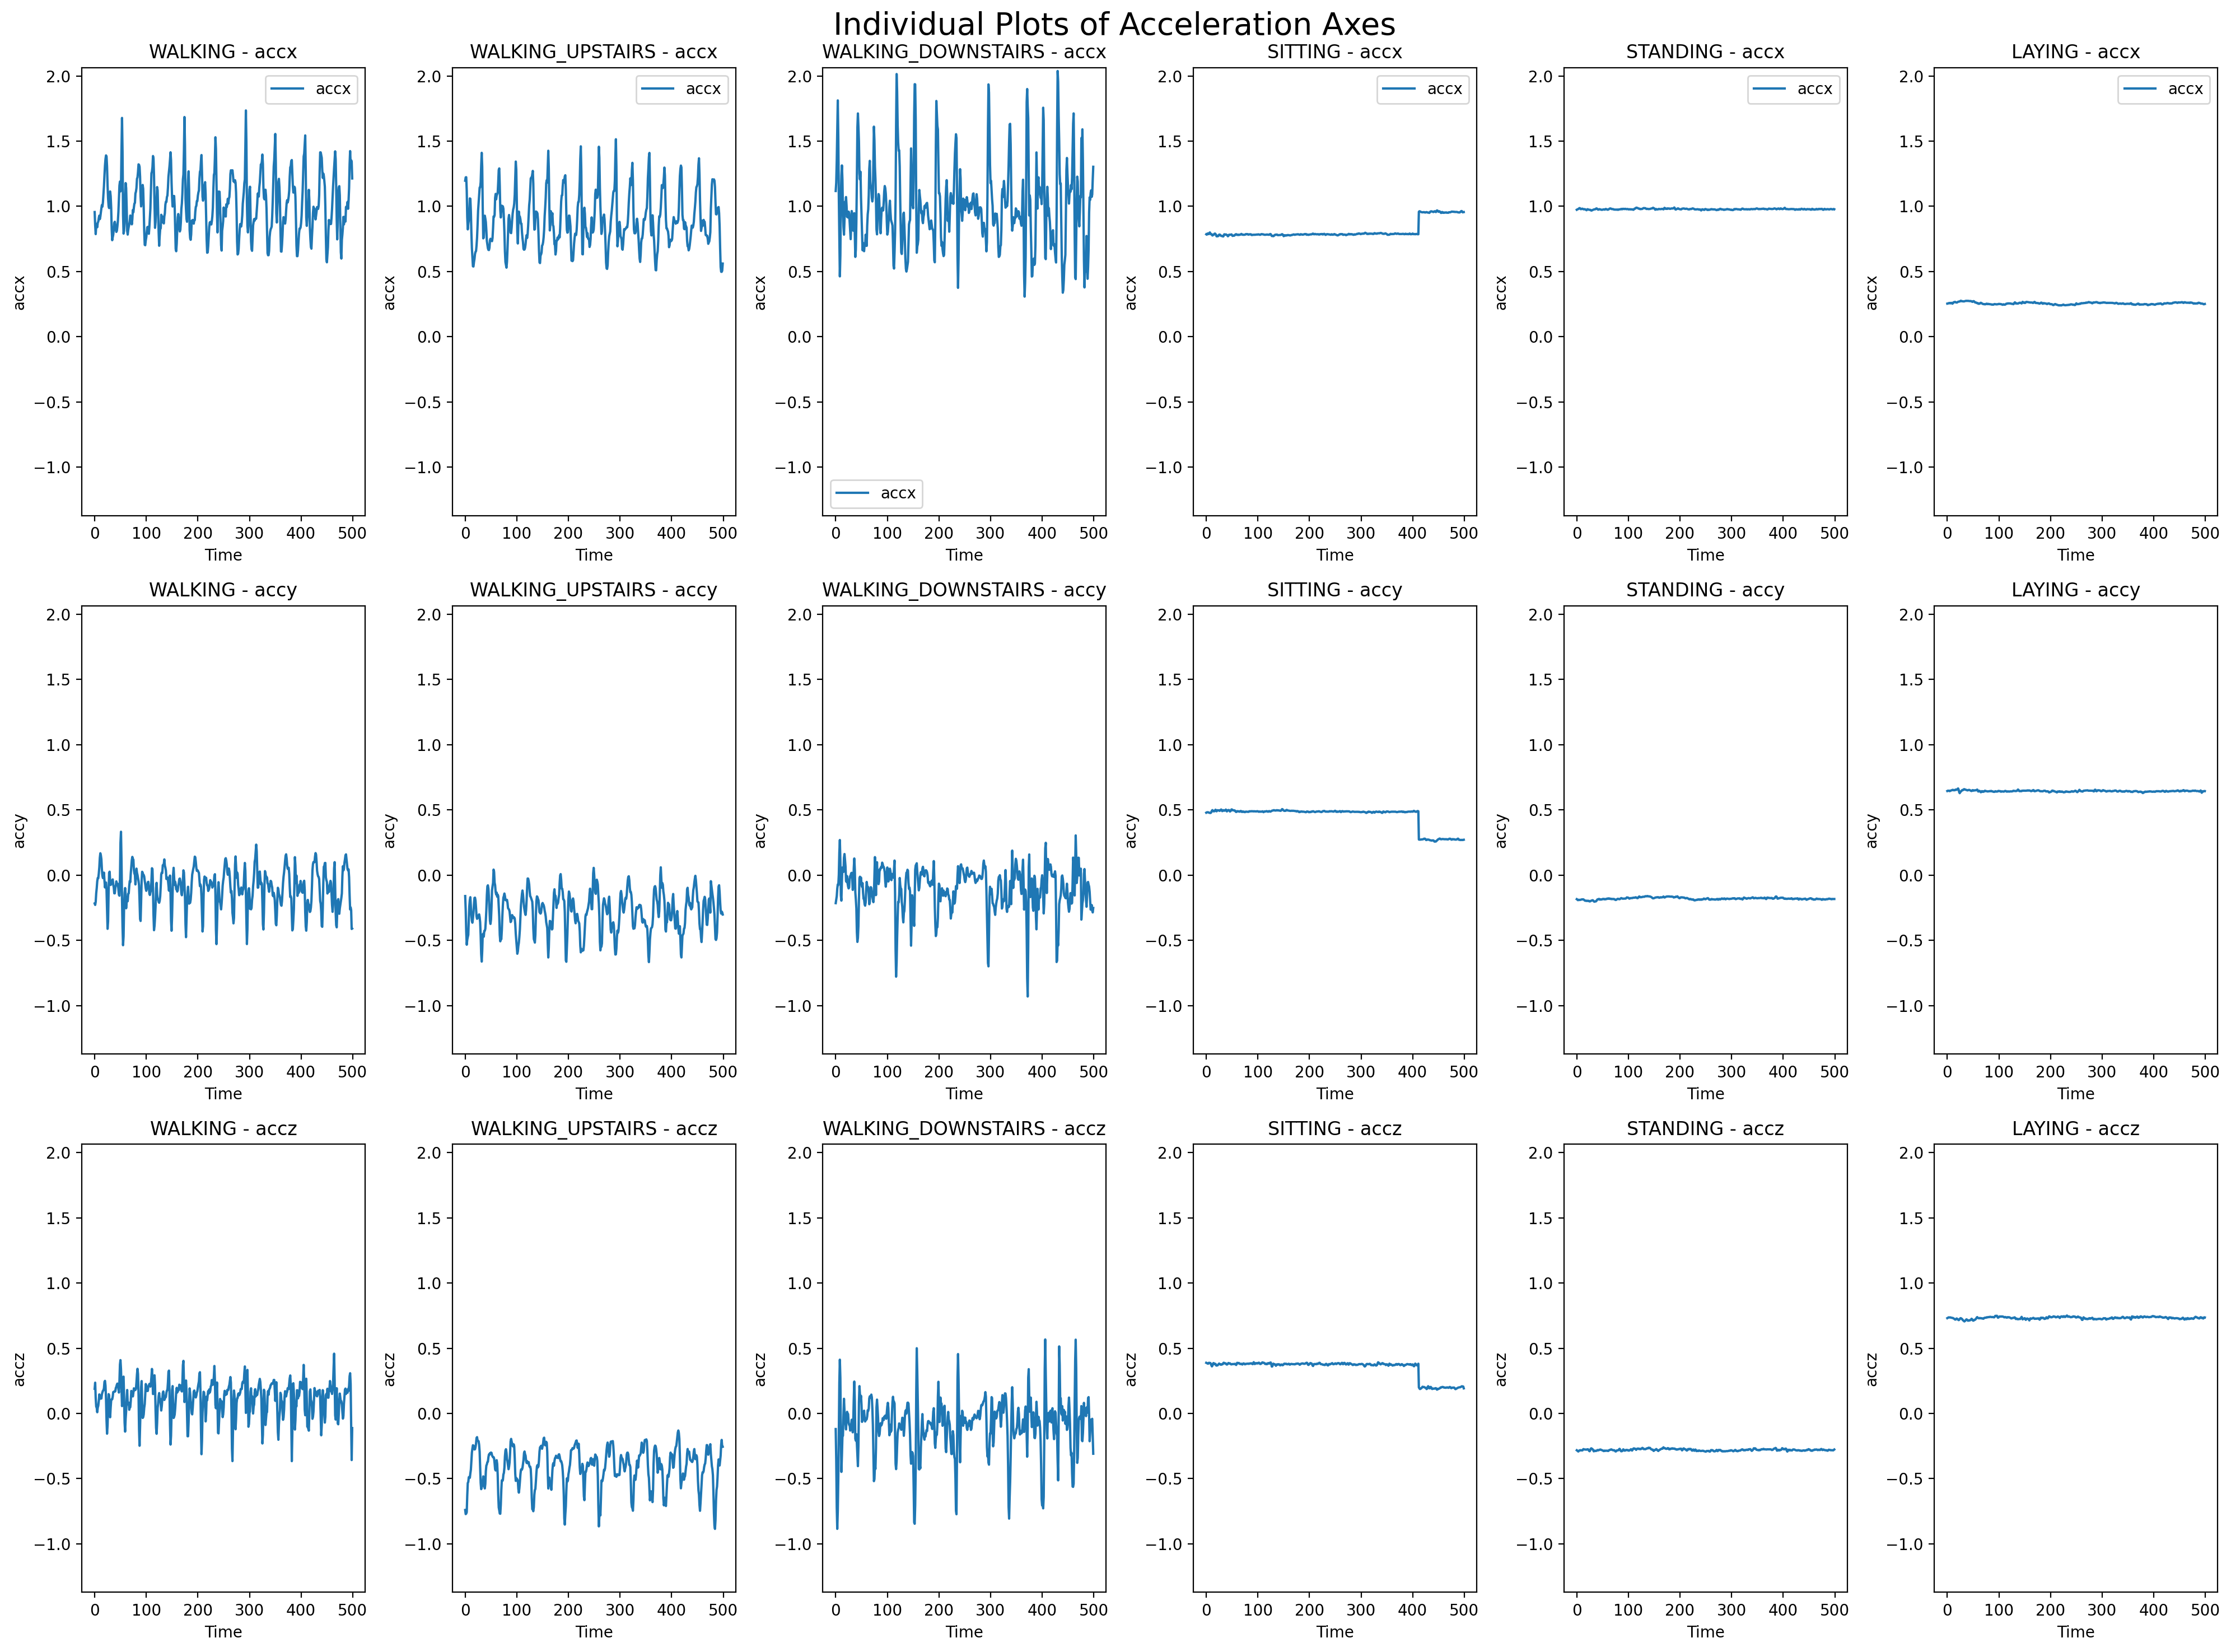

In [14]:
# Find global min and max for consistent scaling
global_min = np.min(X_train)
global_max = np.max(X_train)

# Plotting
fig, axs = plt.subplots(3, len(ACTIVITIES), figsize=(20, 15))
fig.suptitle('Individual Plots of Acceleration Axes', fontsize=20)

# Axis names
axis_names = ['accx', 'accy', 'accz']

for class_id in ACTIVITIES.keys():
    activity = ACTIVITIES[class_id]
    class_data = X_train[y_train == class_id][0]  # Select only the first sample for each class
    col = list(ACTIVITIES.keys()).index(class_id)  # Column index for subplot
    for j, axis in enumerate(axis_names):
        axs[j, col].plot(class_data[:, j], label=axis)
        axs[j, col].set_title(f'{activity} - {axis}', fontsize=12)
        axs[j, col].set_xlabel('Time', fontsize=10)
        axs[j, col].set_ylabel(axis, fontsize=10)
        axs[j, col].set_ylim(global_min, global_max)
        if j == 0:
            axs[j, col].legend()

plt.tight_layout()
plt.show()


*Yes, we are able to observe differences and similarities between the activities:*

- Static Activities (e.g., SITTING, STANDING, LAYING):
These activities show less variation in the waveform, with relatively flat lines or minor oscillations in the acceleration axes.
- Dynamic Activities (e.g., WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS):
These activities exhibit more significant variations in the waveforms, with pronounced peaks and troughs corresponding to the physical movement involved.

*Yes, it is possible to classify the activities based on the data.* The differences in the waveforms between static and dynamic activities provide clear patterns that a machine learning model can leverage for classification. The variations in the accx, accy, and accz axes consistently reflect the nature of the activity, helping the model learn from multiple features simultaneously.

## 2. Do you think we need a machine learning model to differentiate between static activities (laying, sitting, standing) and dynamic activities(walking, walking_downstairs, walking_upstairs)? Look at the linear acceleration $(acc_x^2+acc_y^2+acc_z^2)$ for each activity and justify your answer.

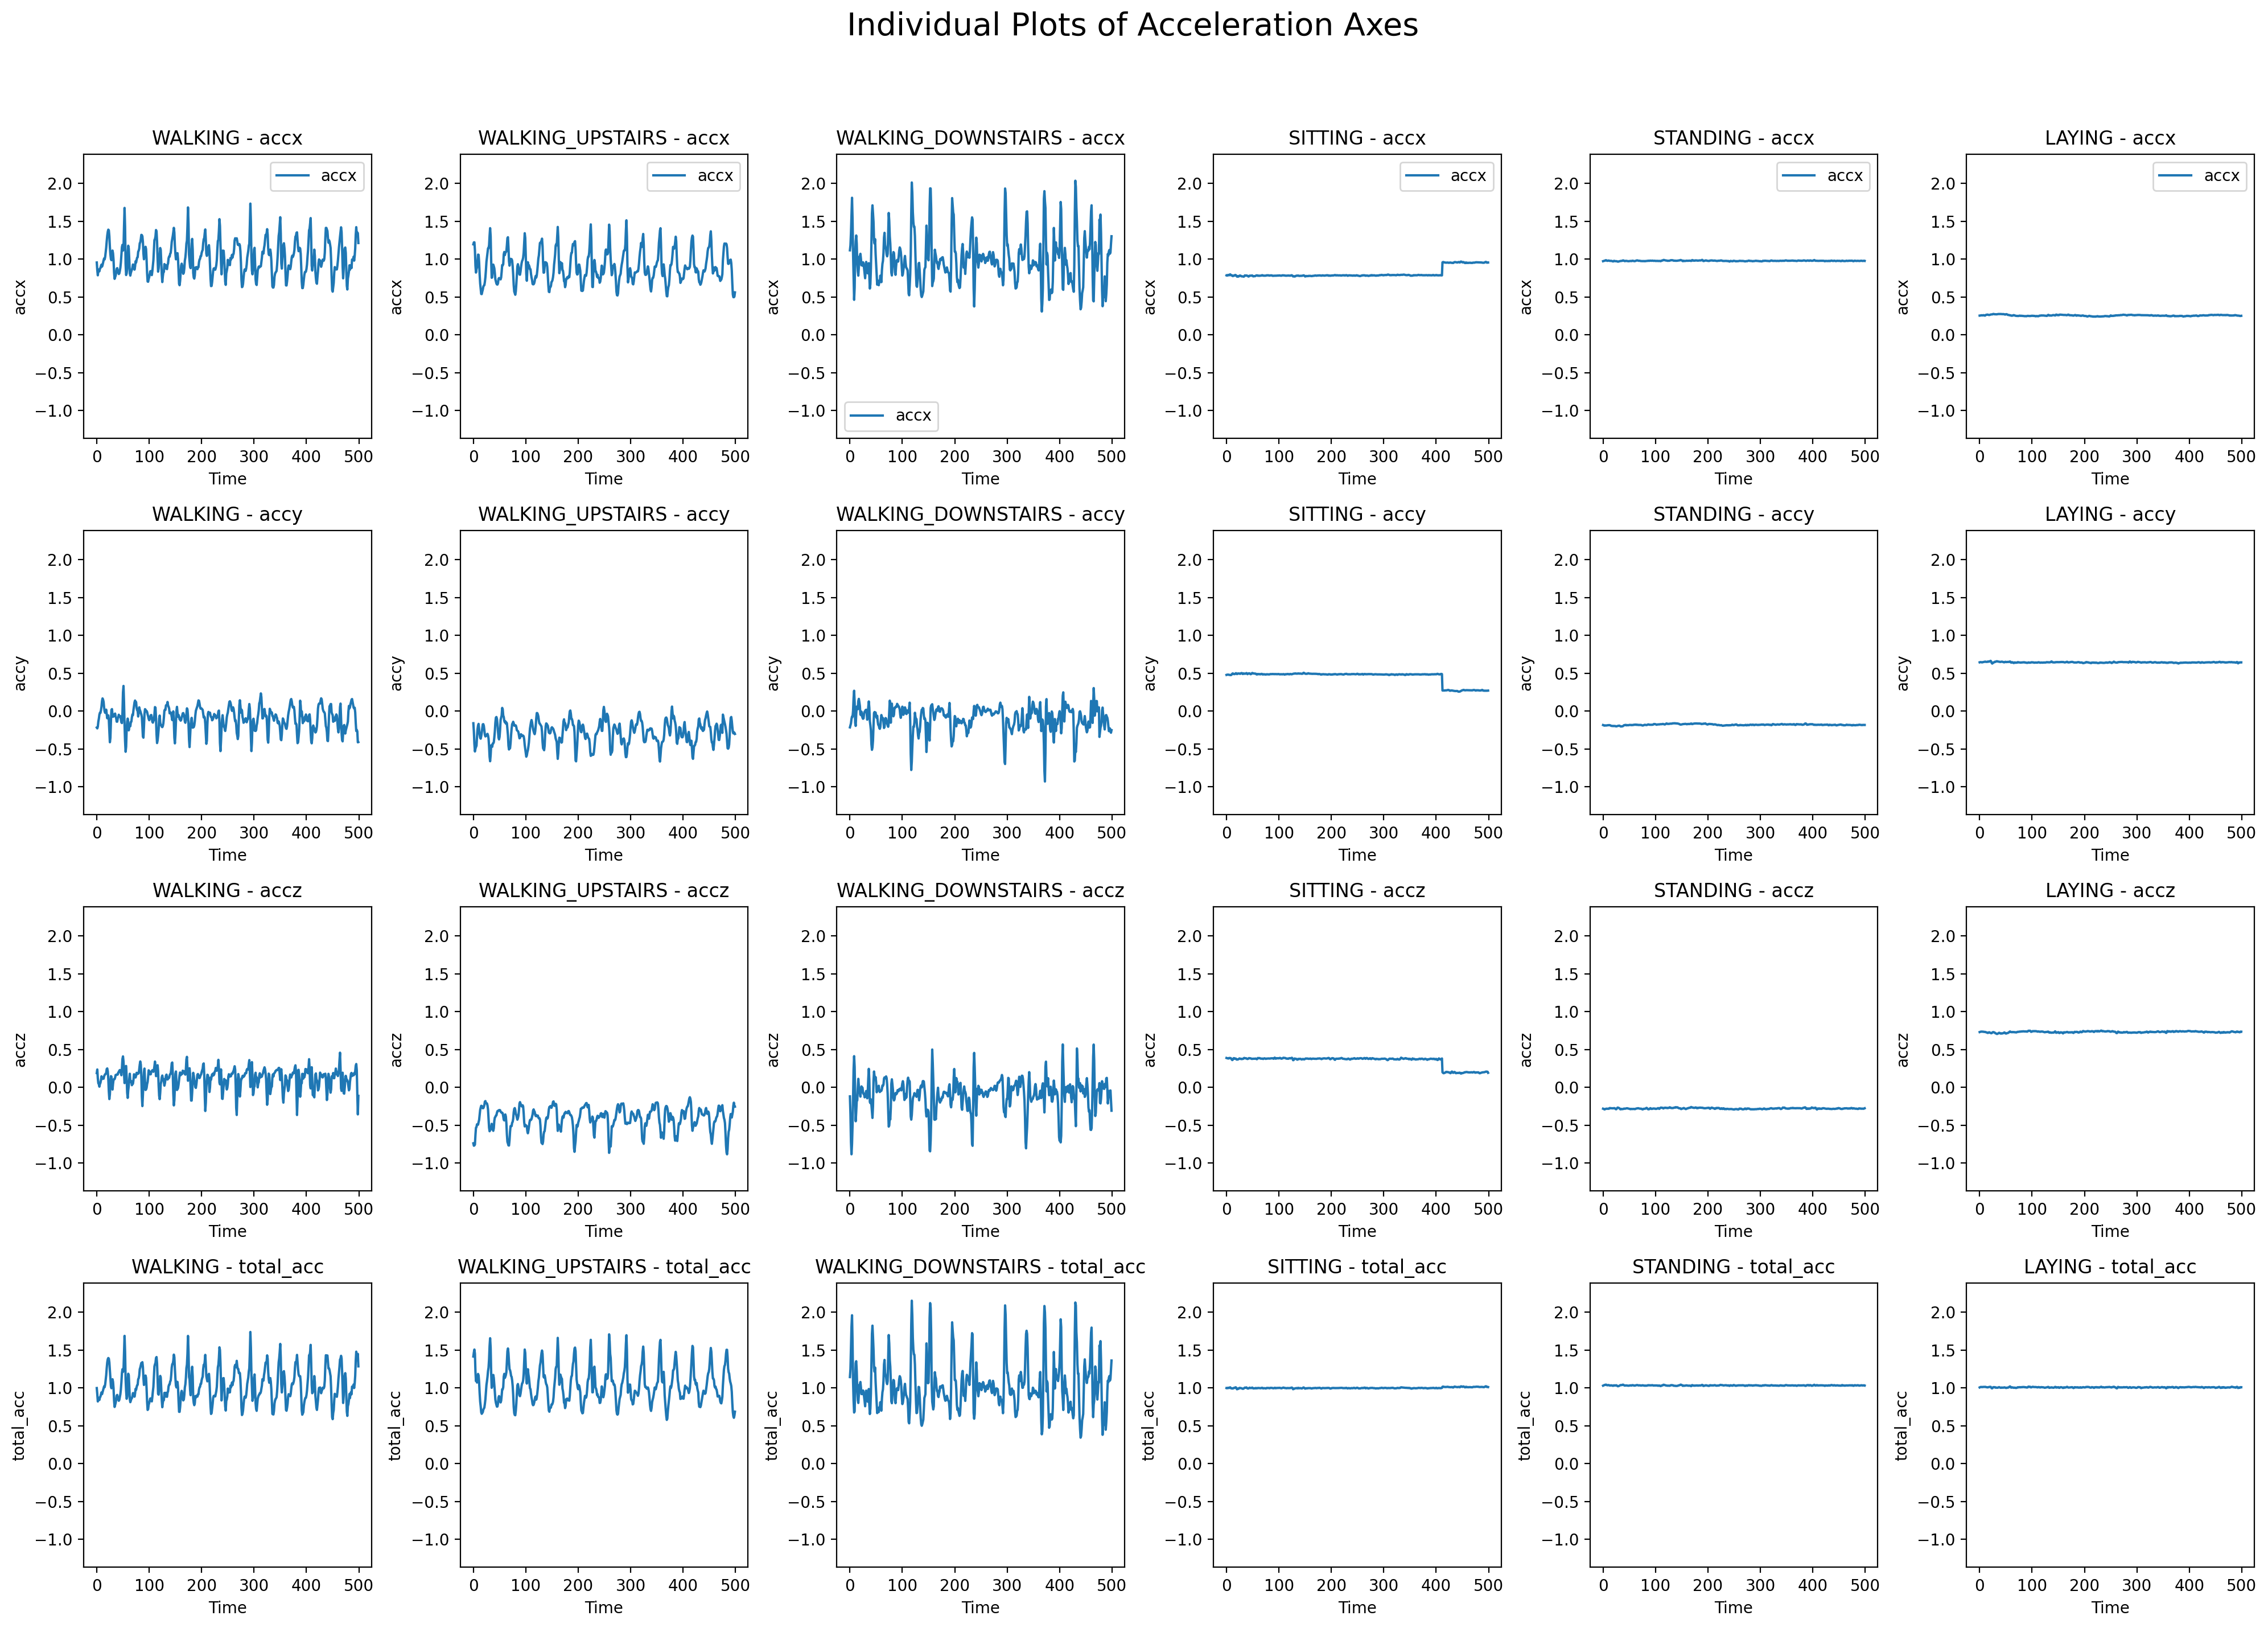

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Find global min and max for consistent scaling
# Reshape total_acc to match X_train's shape for consistent scaling
total_acc_expanded = np.expand_dims(total_acc, axis=-1)  # Add an extra dimension for concatenation

# Compute global min and max values across all features including total_acc
global_min = np.min(np.concatenate([X_train, total_acc_expanded], axis=-1))
global_max = np.max(np.concatenate([X_train, total_acc_expanded], axis=-1))

# Plotting
fig, axs = plt.subplots(4, len(ACTIVITIES), figsize=(20, 15))
fig.suptitle('Individual Plots of Acceleration Axes', fontsize=20)

# Axis names
axis_names = ['accx', 'accy', 'accz', 'total_acc']

for class_id, activity in ACTIVITIES.items():
    class_data = X_train[y_train == class_id][0]  # Select only the first sample for each class
    total_acc_class_data = total_acc[y_train == class_id][0]  # Compute total_acc for each class
    col = list(ACTIVITIES.keys()).index(class_id)  # Column index for subplot
    
    for j, axis in enumerate(axis_names):
        if axis == 'total_acc':
            axs[j, col].plot(total_acc_class_data, label=axis)
        else:
            axis_index = ['accx', 'accy', 'accz'].index(axis)  # Map axis name to index
            axs[j, col].plot(class_data[:, axis_index], label=axis)
        
        axs[j, col].set_title(f'{activity} - {axis}', fontsize=12)
        axs[j, col].set_xlabel('Time', fontsize=10)
        axs[j, col].set_ylabel(axis, fontsize=10)
        axs[j, col].set_ylim(global_min, global_max)
        if j == 0:
            axs[j, col].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for suptitle
plt.show()


##### Do we need a machine learning model?

- Observation of Total Acceleration:

1. By observing the total acceleration (accx^2 + accy^2 + accz^2) across different activities, it's evident that static activities (like LAYING, SITTING, and STANDING) show significantly less variance compared to dynamic activities (like WALKING, WALKING_DOWNSTAIRS, WALKING_UPSTAIRS).
Static activities exhibit nearly constant total acceleration with very minor fluctuations, while dynamic activities have clear patterns of peaks and troughs that correlate with physical movement.
Classification Without Machine Learning:

2. The substantial difference in the variance of total acceleration between static and dynamic activities suggests that a simple threshold-based approach could effectively distinguish between these two types of activities.
For instance, one could set a threshold on the variance or the standard deviation of the total acceleration to classify whether an activity is static or dynamic. This would eliminate the need for a complex machine learning model, as the differences are quite apparent and can be captured with basic statistical measures.
Conclusion:

- No: Based on the variance in total acceleration, it is likely not necessary to use a machine learning model to differentiate between static and dynamic activities. The clear distinction in the signal's variance is sufficient to classify the activities without a sophisticated model accurately. To classify it, we can look below for a rule-based example of the total acceleration approach.


In [16]:
import numpy as np

# Calculate the variance of total_acceleration for each activity
variances = []
for class_id in ACTIVITIES.keys():
    total_acc_class_data = total_acc[y_train == class_id]  # Get total_acc for each class
    variance = np.var(total_acc_class_data)
    variances.append(variance)

# Normalize the variances (max variance will be 1)
max_variance = max(variances)
variances_normalized = [v / max_variance for v in variances]

# Define a threshold to differentiate static and dynamic activities
threshold = np.median(variances_normalized)
print(f'Threshold for classification (normalized scale): {threshold:.4f}\n')

# Print the normalized variances for each activity
for i, variance in enumerate(variances_normalized):
    activity_type = 'Dynamic' if variance > threshold else 'Static'
    print(f'{ACTIVITIES[i+1]}: Normalized Variance = {variance:.4f} ({activity_type})')


Threshold for classification (normalized scale): 0.1858

WALKING: Normalized Variance = 0.3707 (Dynamic)
WALKING_UPSTAIRS: Normalized Variance = 0.5323 (Dynamic)
WALKING_DOWNSTAIRS: Normalized Variance = 1.0000 (Dynamic)
SITTING: Normalized Variance = 0.0009 (Static)
STANDING: Normalized Variance = 0.0004 (Static)
LAYING: Normalized Variance = 0.0006 (Static)


## 3. Visualize the data using PCA.

### i. Use PCA (Principal Component Analysis) on Total Acceleration $(acc_x^2+acc_y^2+acc_z^2)$ to compress the acceleration timeseries into two features and plot a scatter plot to visualize different class of activities. 


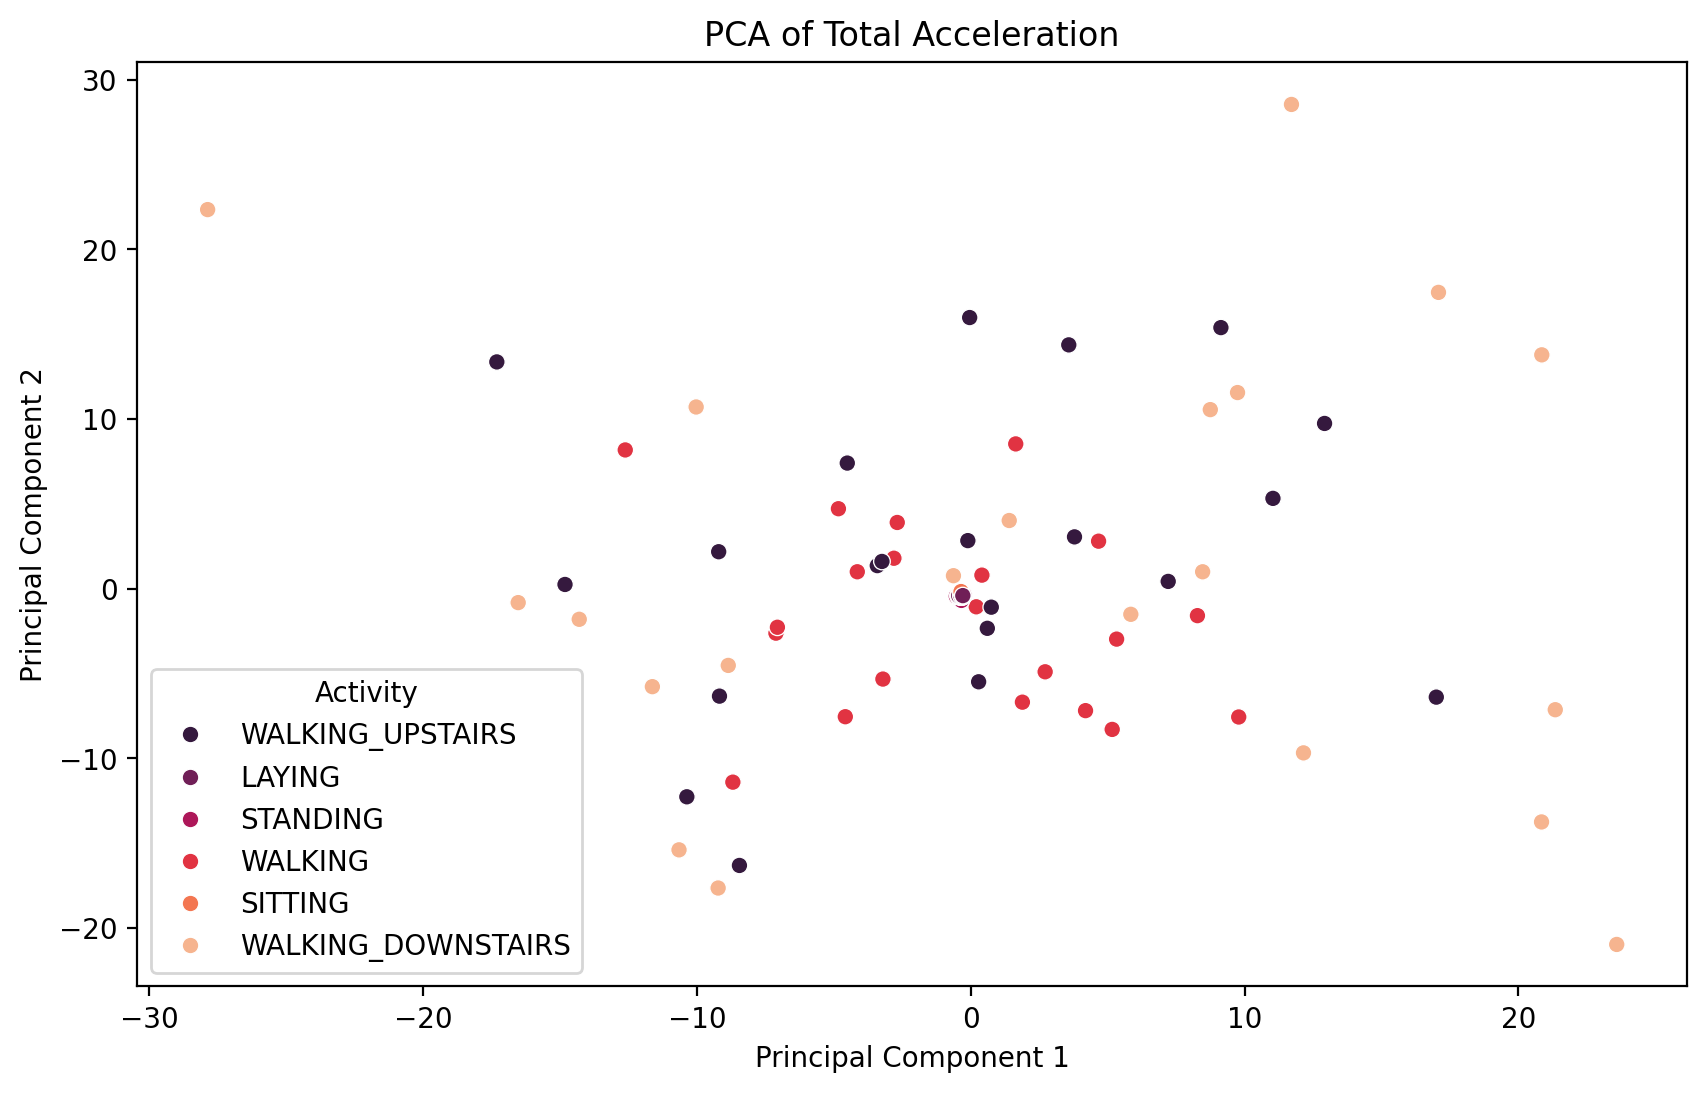

In [17]:
# Standardize the total acceleration data
scaler = StandardScaler()
total_acc_scaled = scaler.fit_transform(total_acc)

# Perform PCA to reduce dimensions from 500 to 2
# Compute the covariance matrix
cov_matrix = np.cov(total_acc_scaled, rowvar=False)

# Compute the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort the eigenvectors by eigenvalues in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
top_eigenvectors = eigenvectors[:, sorted_indices[:2]]

# Project the data onto the top 2 eigenvectors
pca_result = total_acc_scaled.dot(top_eigenvectors)

# Create a DataFrame for easier plotting
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
df_pca['Activity'] = [ACTIVITIES[activity] for activity in y_train]  # Use dictionary for activity names

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Activity', palette='rocket', legend='full')
plt.title('PCA of Total Acceleration')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Activity')
plt.show()


### ii. Next, use [TSFEL](https://tsfel.readthedocs.io/en/latest/) ([a featurizer library](https://github.com/fraunhoferportugal/tsfel)) to create features (your choice which ones you feel are useful) and then perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities. 

,PC1,PC2,Activity
0,2.982394,3.028660,WALKING_UPSTAIRS
1,-10.732756,-5.771675,LAYING
2,-8.841784,3.233533,STANDING
3,4.231199,1.817060,WALKING_UPSTAIRS
4,5.775037,3.131938,WALKING_UPSTAIRS
...,...,...,...
121,6.570750,2.612109,WALKING
122,-7.987812,2.325851,SITTING
123,-10.607540,-2.318163,LAYING
124,7.071959,-0.791218,WALKING_UPSTAIRS


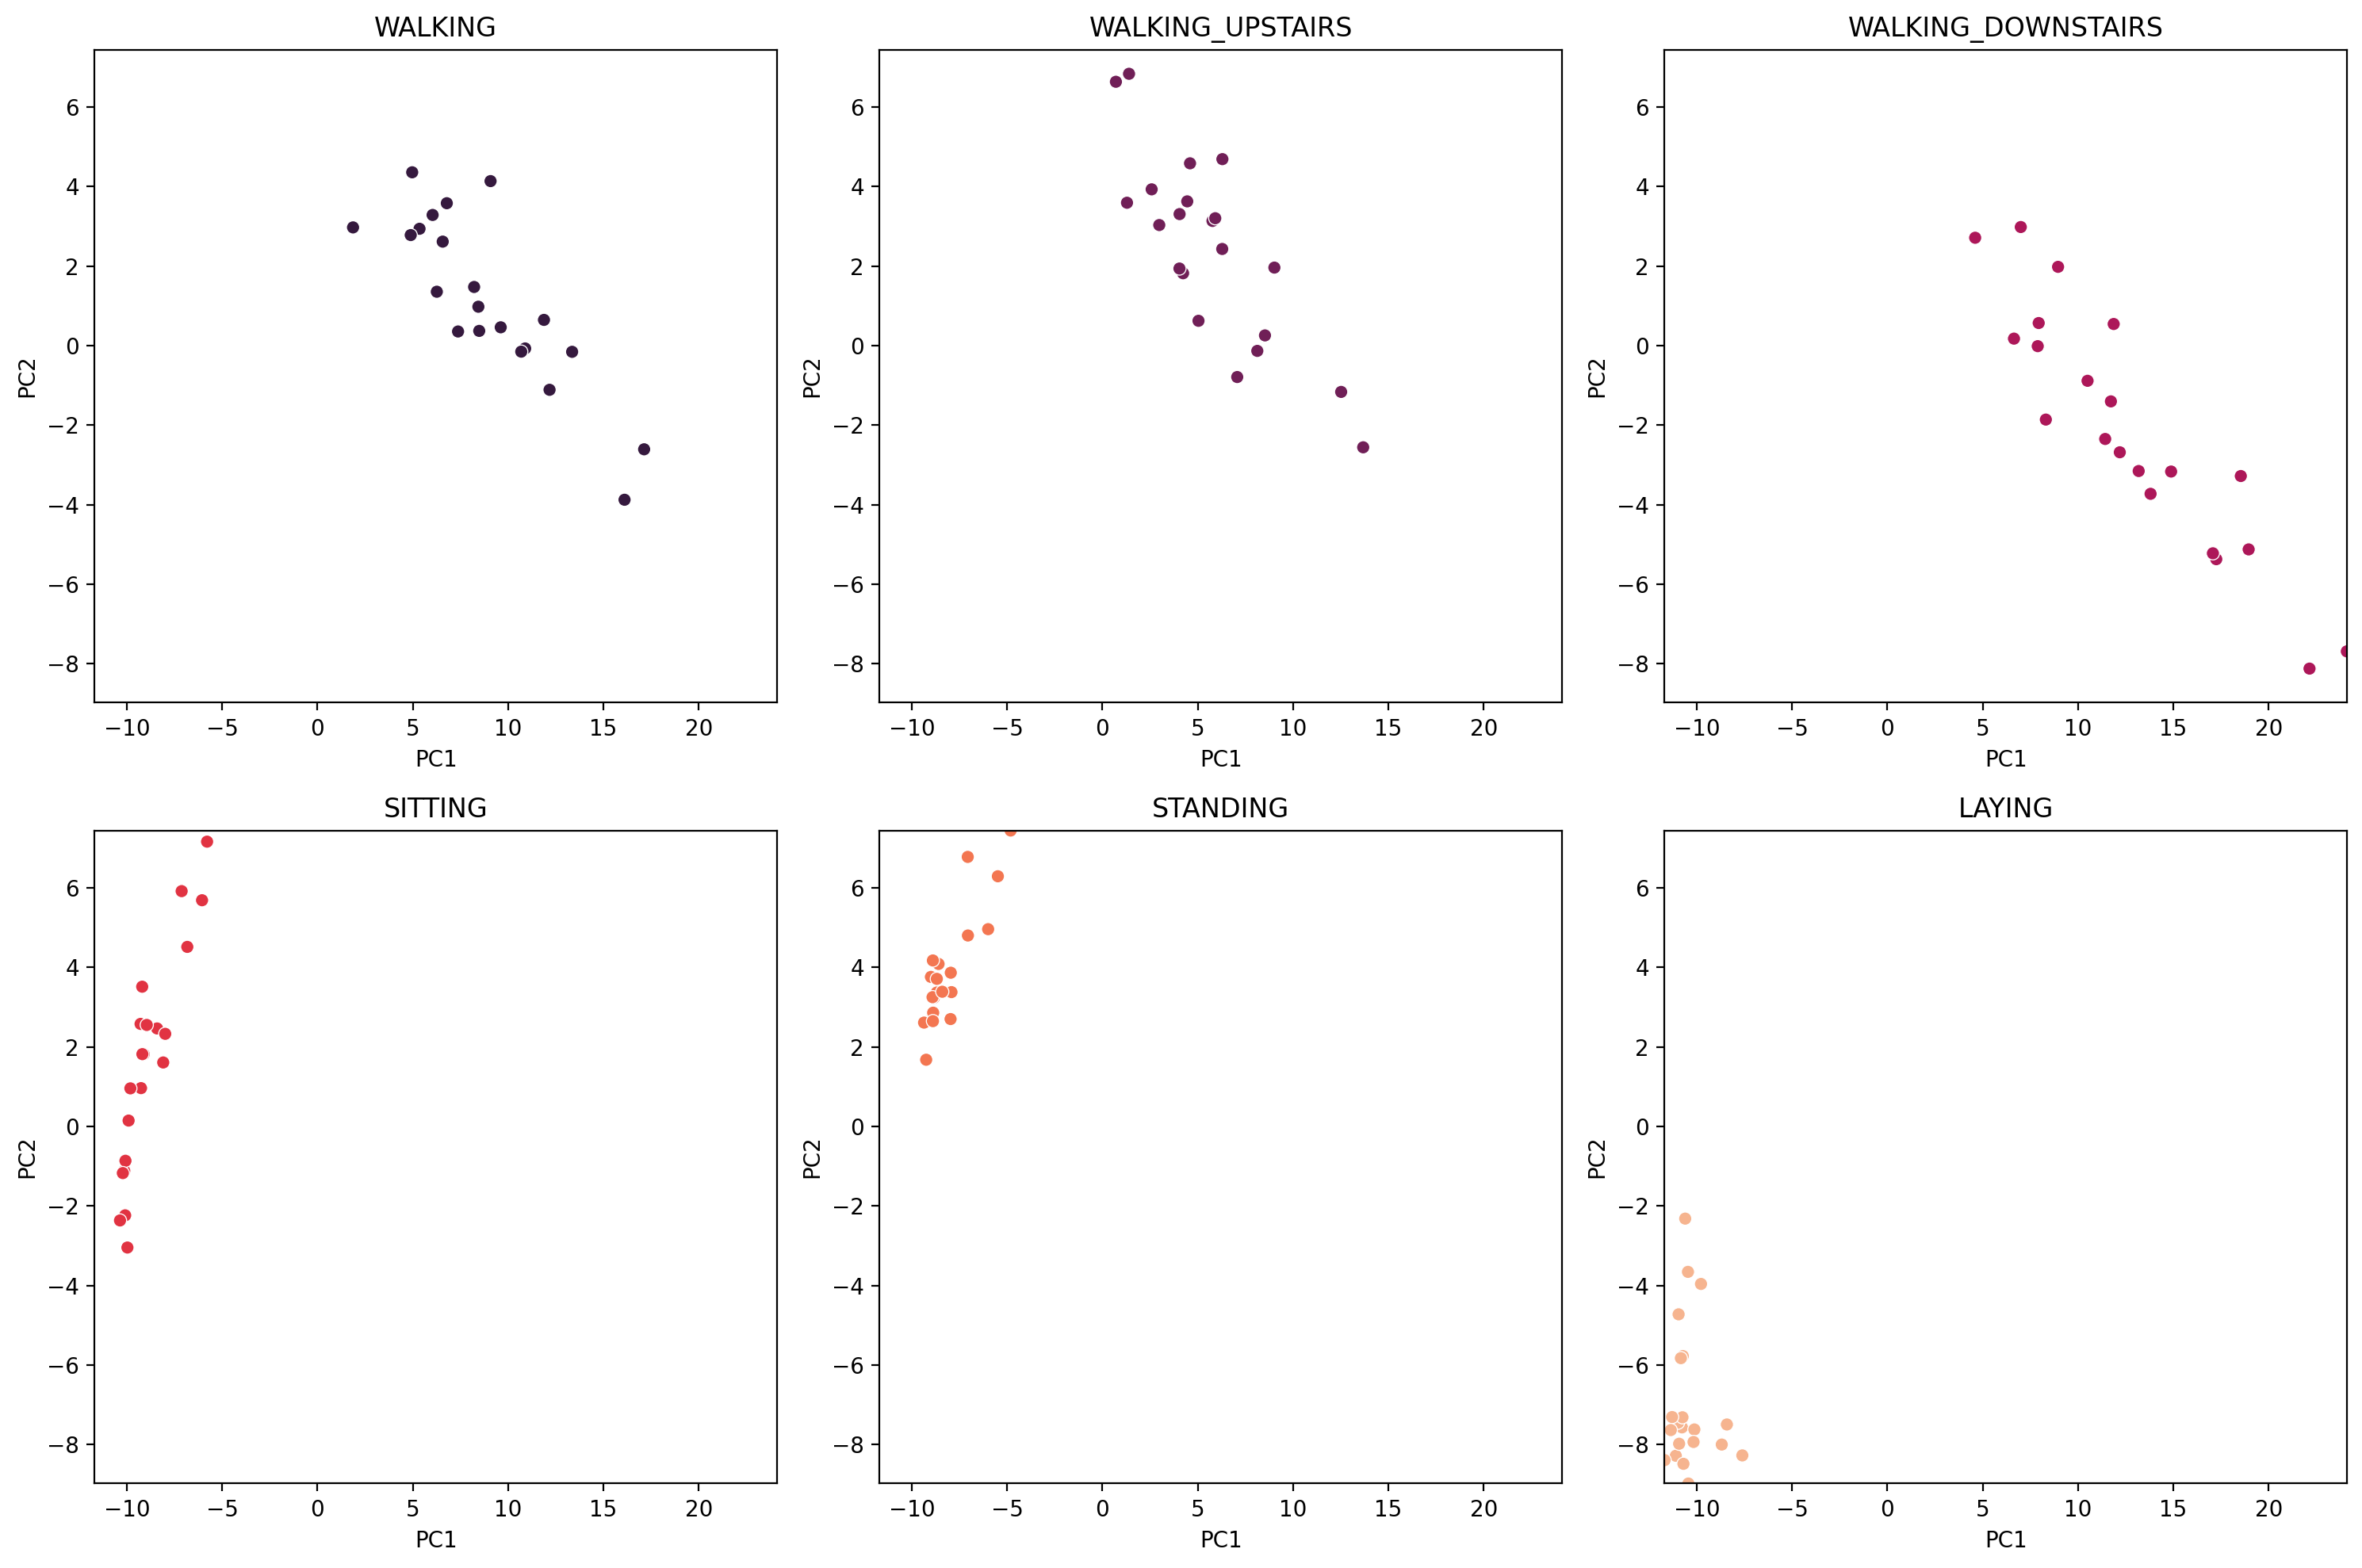

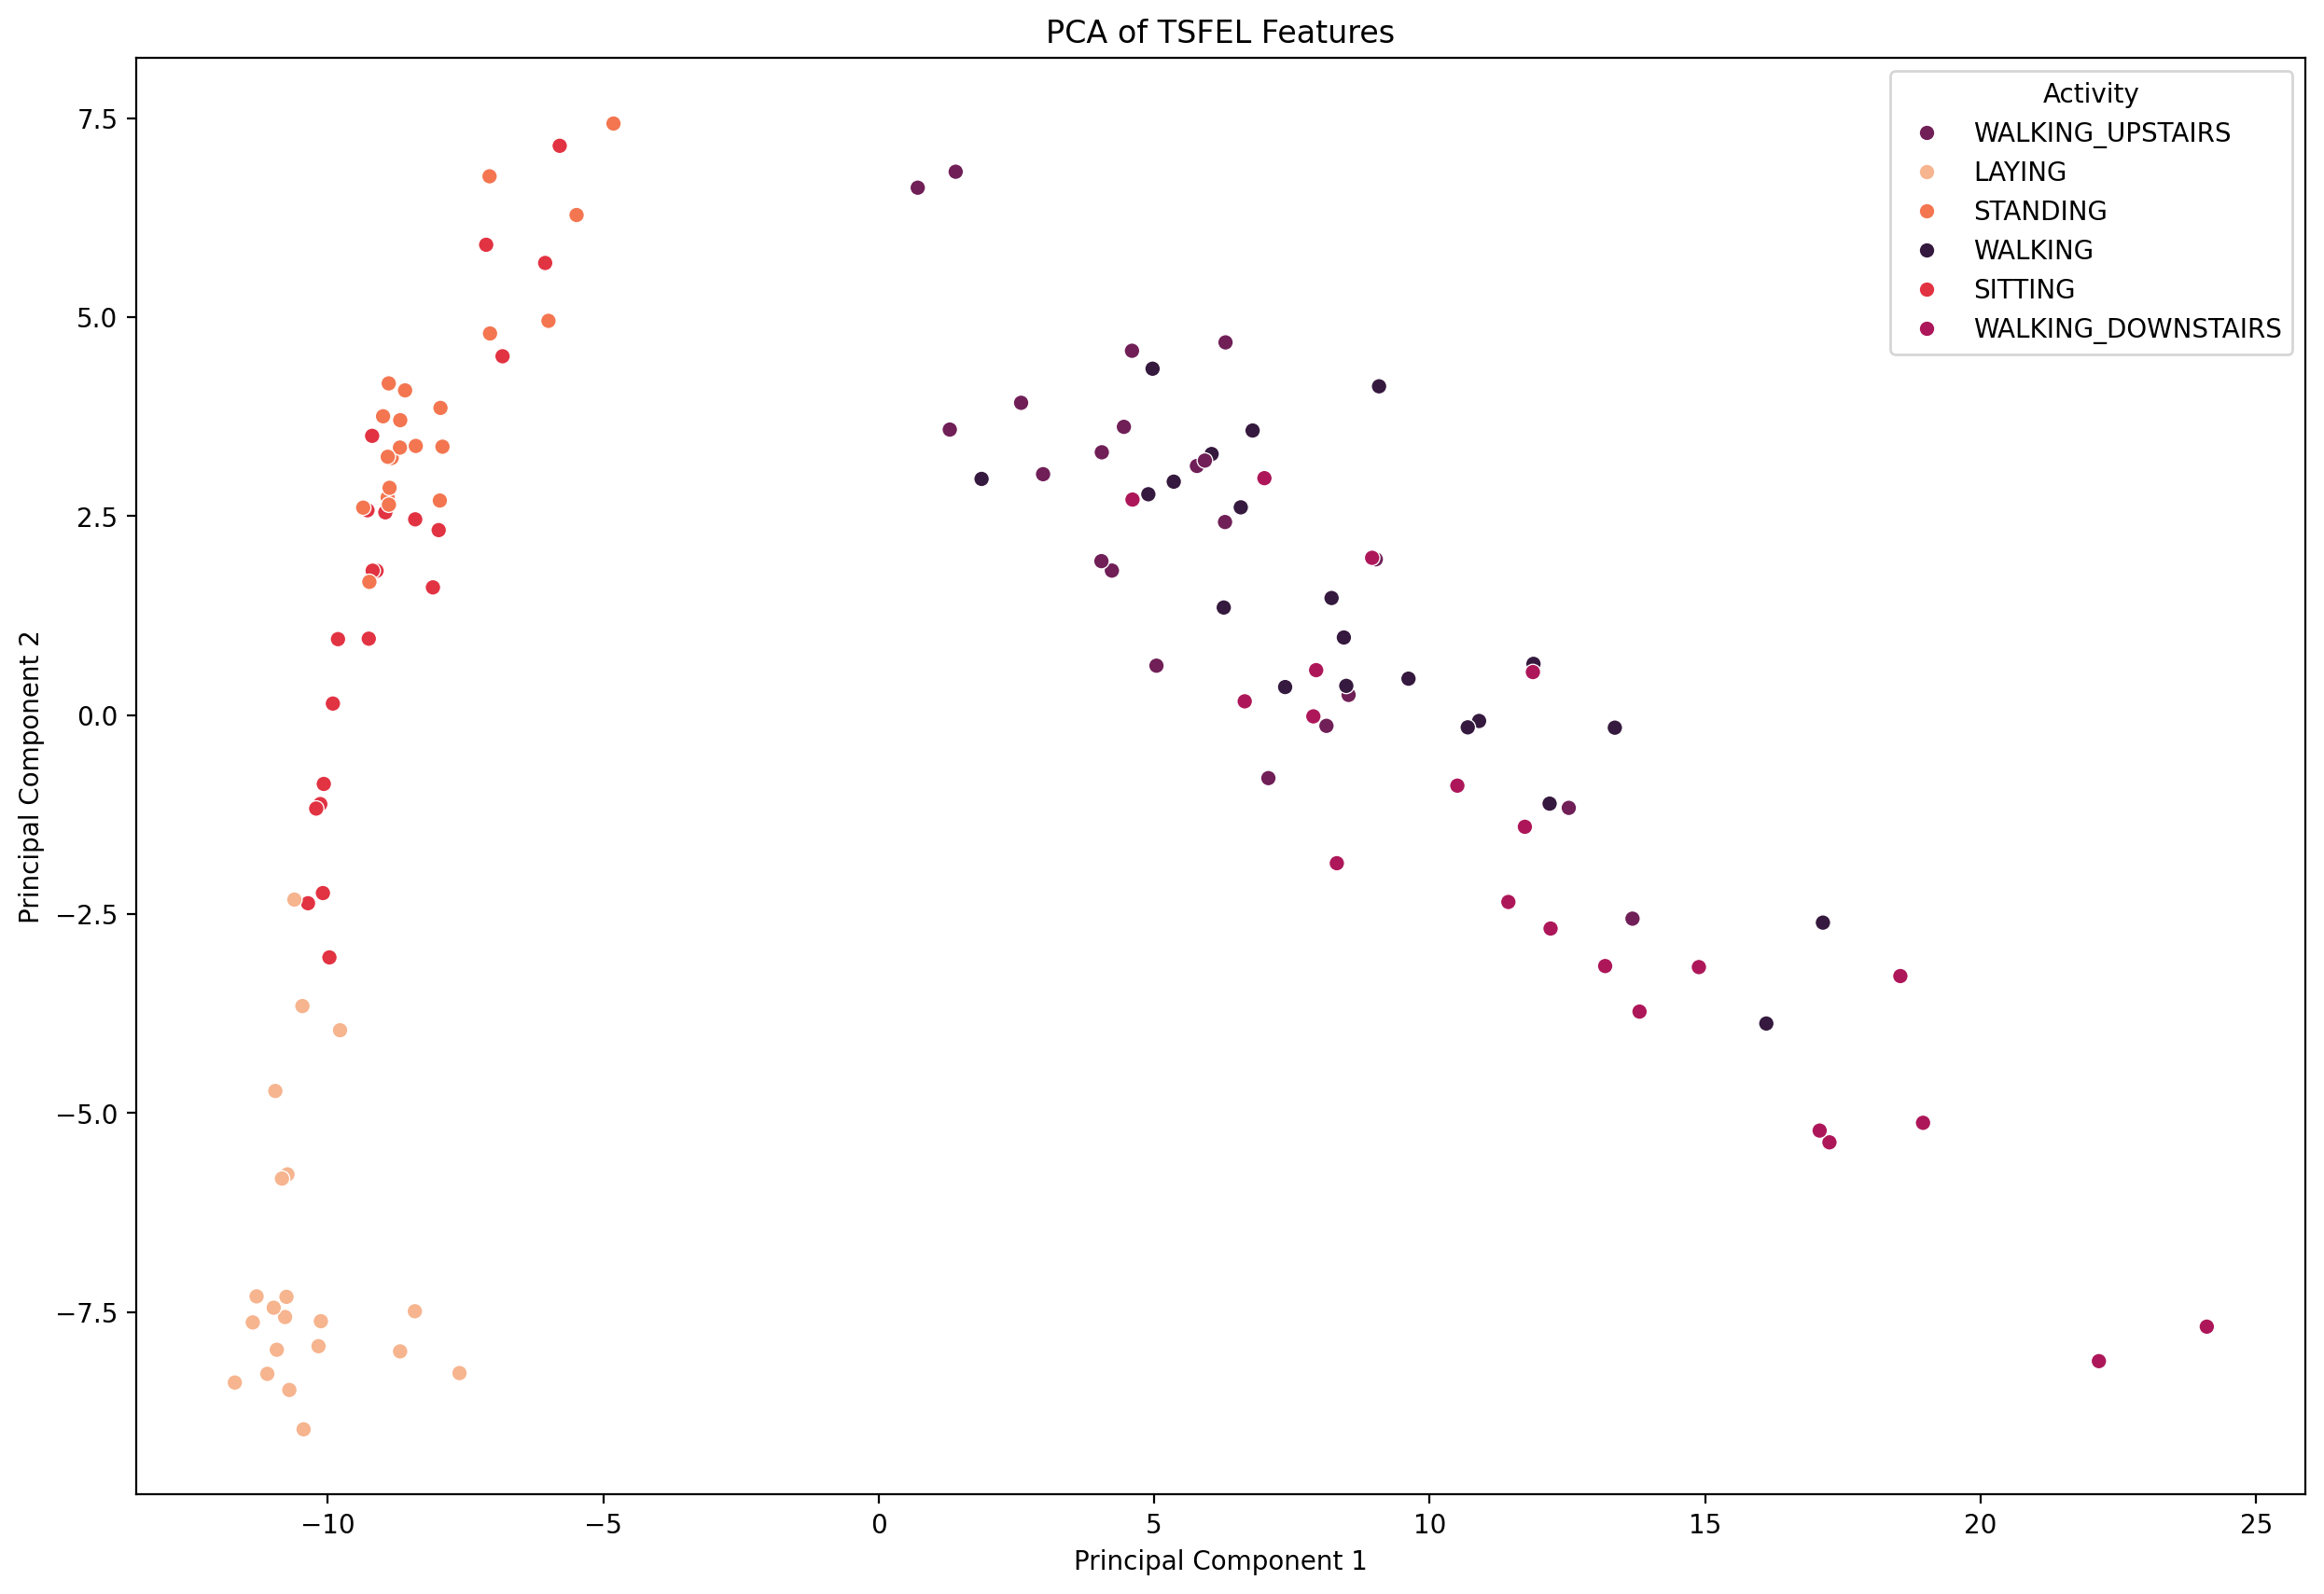

In [18]:
# Step 1: Feature Extraction
cfg_file, fs = tsfel.get_features_by_domain(), 50
X_features = tsfel.time_series_features_extractor(cfg_file, X_train, fs=fs)
X_features_features = list(X_features)

# Remove highly correlated features
corr_features = tsfel.correlated_features(X_features)
X_features.drop(corr_features, axis=1, inplace=True)

# Remove low variance features
selector = VarianceThreshold()
X_features = selector.fit_transform(X_features)

# Normalize features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_features)

# Step 3: PCA for Dimensionality Reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Create a DataFrame for easier plotting
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca_f = df_pca
df_pca['Activity'] = [ACTIVITIES[activity] for activity in y_train]
display(df_pca)

df_pca.to_csv('df_pca.csv', index=False)

# Determine common x and y limits from the combined plot data
xlim = (df_pca['PC1'].min(), df_pca['PC1'].max())
ylim = (df_pca['PC2'].min(), df_pca['PC2'].max())

# Define the color palette
colors = sns.color_palette("rocket", n_colors=len(ACTIVITIES))
activity_colors = {activity: colors[i] for i, activity in enumerate(ACTIVITIES.values())}

# Step 4: Individual Scatter Plots for Each Activity
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Plot each activity individually with consistent scales
for i, (activity_num, activity_name) in enumerate(ACTIVITIES.items()):
    df_pca_activity = df_pca[df_pca['Activity'] == activity_name]
    sns.scatterplot(data=df_pca_activity, x="PC1", y="PC2", hue="Activity", palette=[activity_colors[activity_name]], ax=axs[i], legend=False)
    axs[i].set_title(activity_name)
    axs[i].set_xlabel("PC1")
    axs[i].set_ylabel("PC2")
    axs[i].set_xlim(xlim)
    axs[i].set_ylim(ylim)

# Adjust layout for better spacing
plt.tight_layout()


# Step 4: Visualization
plt.figure(figsize=(15, 10))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Activity', palette=activity_colors, legend='full')
plt.title('PCA of TSFEL Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Activity')
plt.show()



### iii. Now use the features provided by the dataset and perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities.

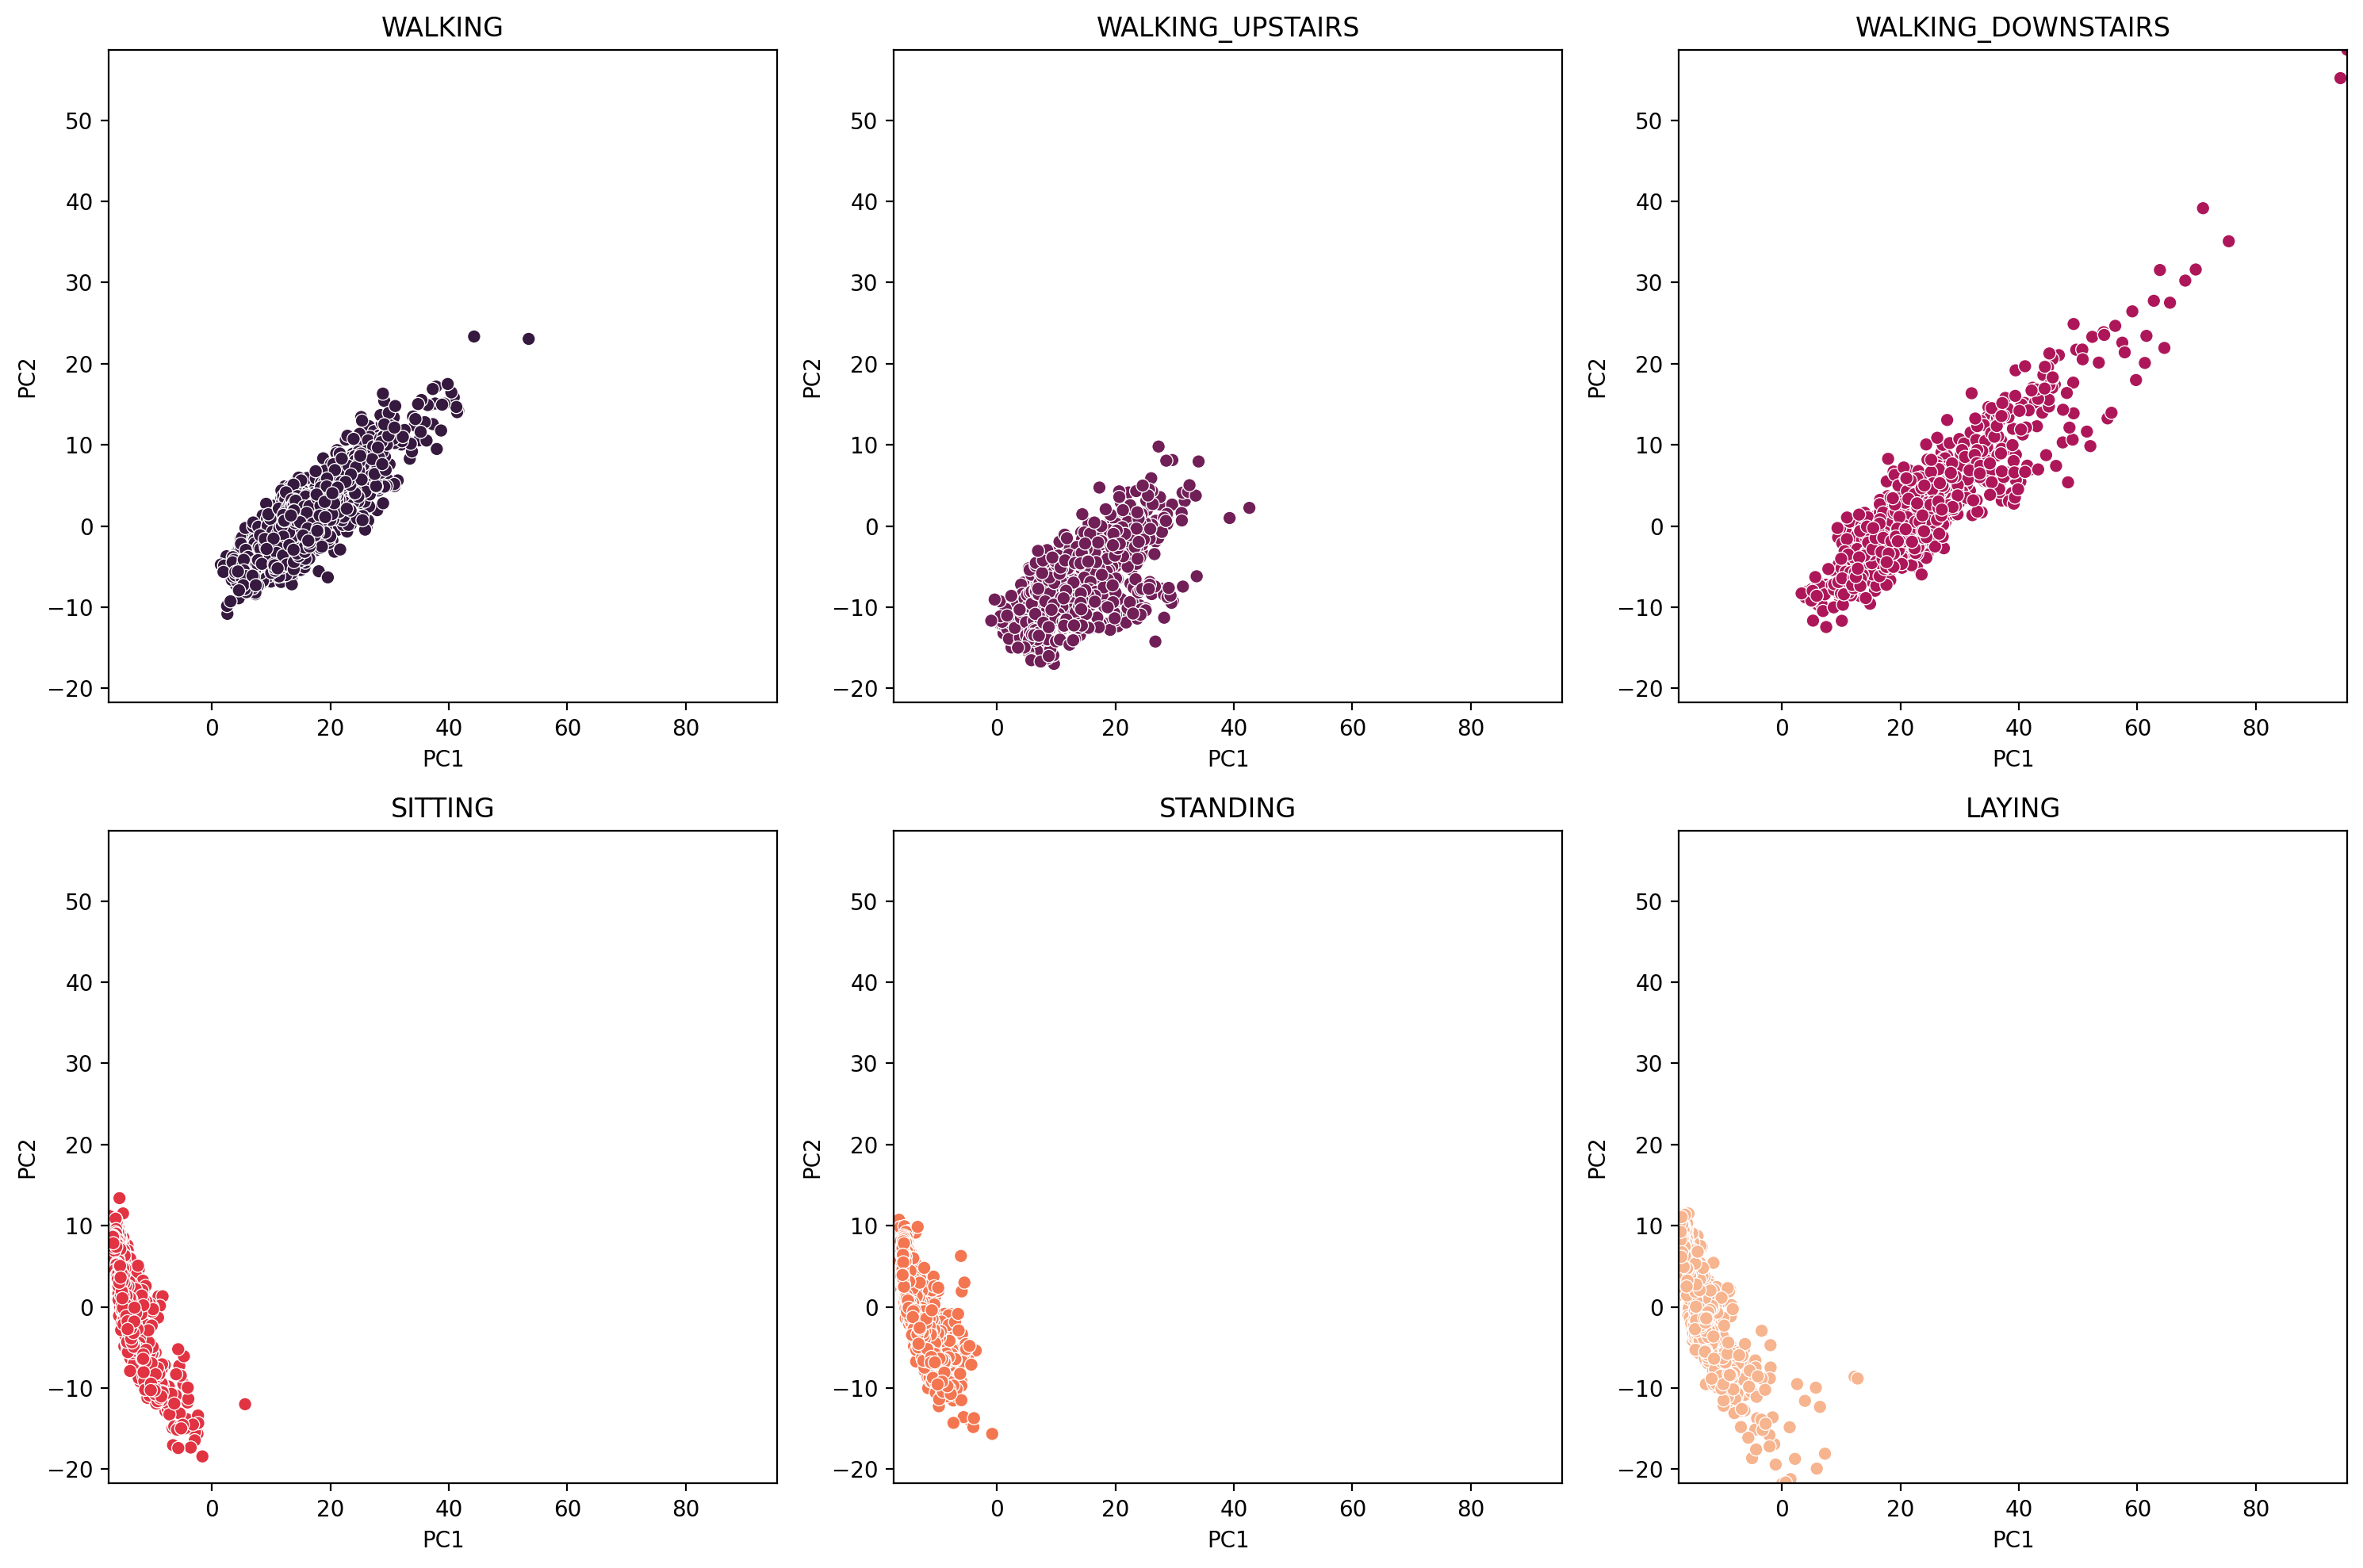

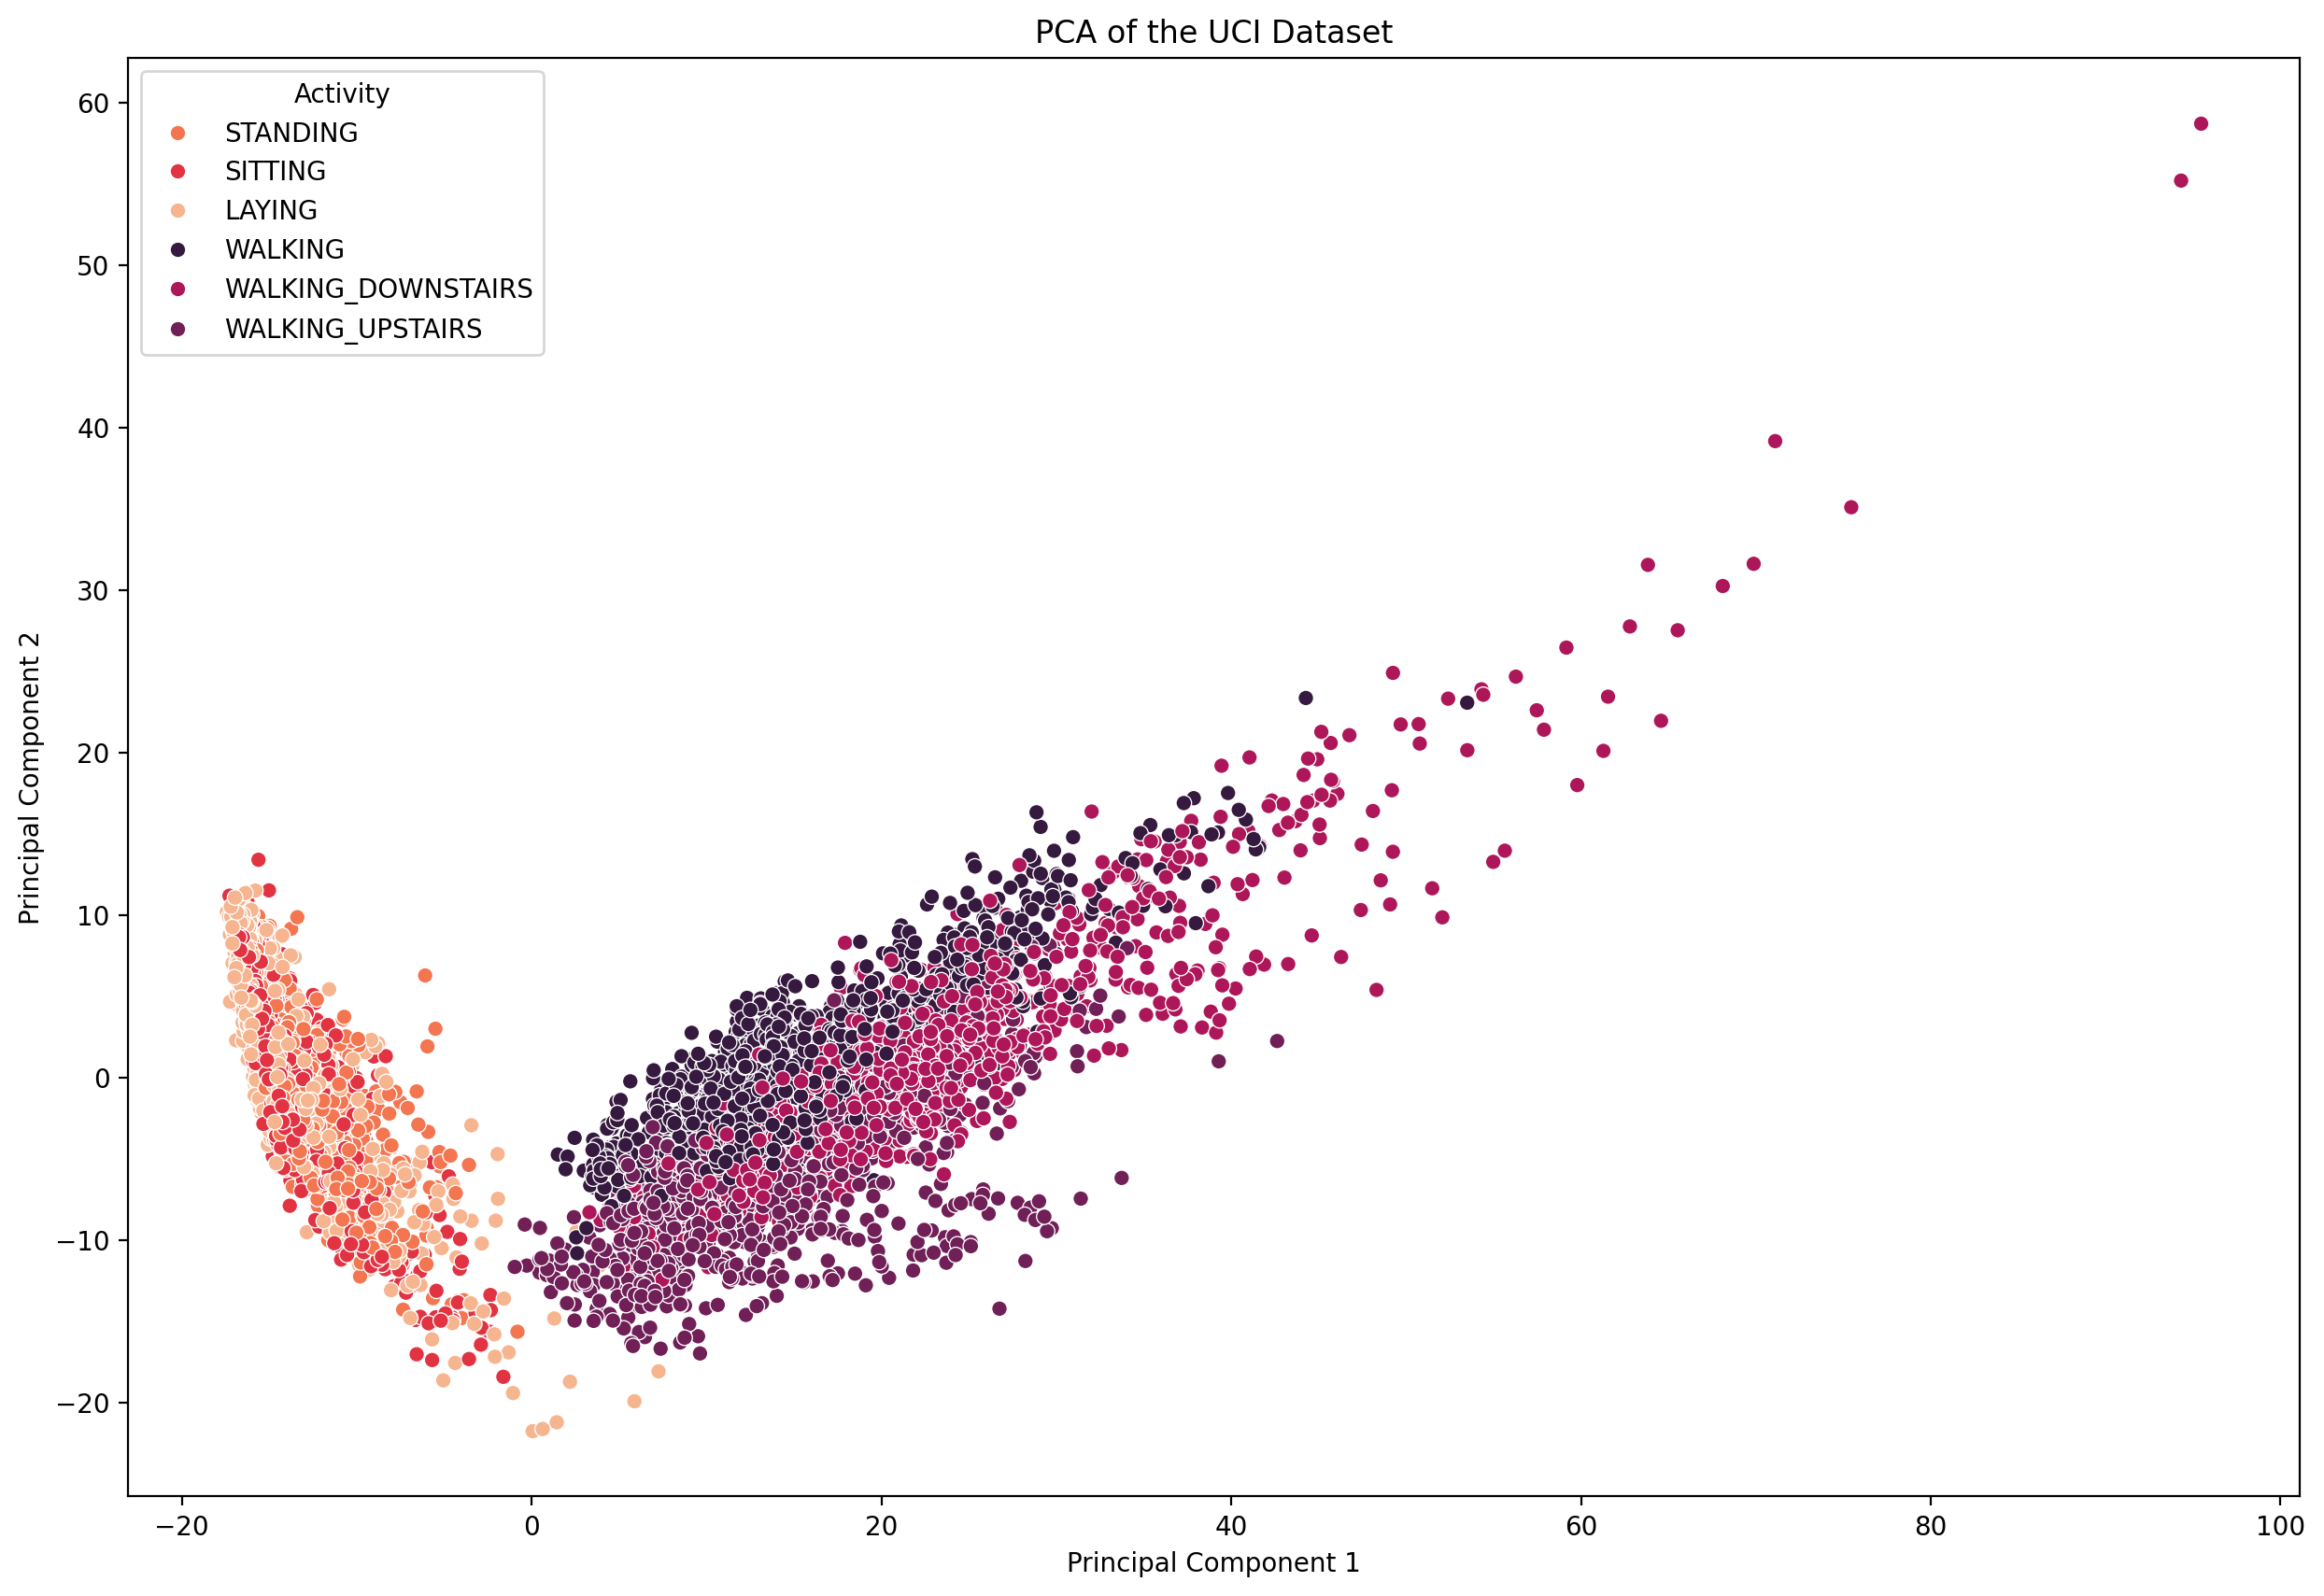

In [19]:
X_train_arranged = pd.read_csv(os.path.join(train_path, "X_train.txt"), sep=r'\s+', header=None)
y_train_arranged = pd.read_csv(os.path.join(train_path, "y_train.txt"), sep=r'\s+', header=None)

# Standardize the data
scaler = StandardScaler()
X_arranged_normalized = scaler.fit_transform(X_train_arranged)

# PCA for dimensionality reduction
pca = PCA(n_components=2)
X_arranged_pca = pca.fit_transform(X_arranged_normalized)

# Create a DataFrame
df_pca_x_arranged = pd.DataFrame(X_arranged_pca, columns=["PC1", "PC2"])
df_pca_x_arranged_f = df_pca_x_arranged
df_pca_x_arranged['Activity'] = [ACTIVITIES[activity] for activity in y_train_arranged[0]]

# Define consistent x and y limits
xlim = (df_pca_x_arranged['PC1'].min(), df_pca_x_arranged['PC1'].max())
ylim = (df_pca_x_arranged['PC2'].min(), df_pca_x_arranged['PC2'].max())

# Define the color palette
colors = sns.color_palette("rocket", n_colors=len(ACTIVITIES))
activity_colors = {activity: colors[i] for i, activity in enumerate(ACTIVITIES.values())}


# Step 4: Individual Scatter Plots for Each Activity
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Plot each activity individually with consistent scales
for i, (activity_num, activity_name) in enumerate(ACTIVITIES.items()):
    df_pca_activity = df_pca_x_arranged[df_pca_x_arranged['Activity'] == activity_name]
    sns.scatterplot(data=df_pca_activity, x="PC1", y="PC2", hue="Activity", palette=[activity_colors[activity_name]], ax=axs[i], legend=False)
    axs[i].set_title(activity_name)
    axs[i].set_xlabel("PC1")
    axs[i].set_ylabel("PC2")
    axs[i].set_xlim(xlim)
    axs[i].set_ylim(ylim)

# Adjust layout for better spacing
plt.tight_layout()

# Step 5: Combined Scatter Plot for All Activities
plt.figure(figsize=(15, 10))
sns.scatterplot(data=df_pca_x_arranged, x="PC1", y="PC2", hue="Activity", palette=activity_colors, legend="full")
plt.title("PCA of the UCI Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Activity")
plt.show()


### iv. Compare the results of PCA on Total Acceleration, TSFEL and the dataset features. Which method do you think is better for visualizing the data?

#### The results of PCA on the dataset features offer better visualization compared to PCA on TSFEL and Total Acceleration, as it produces more distinct and clustered activity separations. This is because the dataset features include a *richer set of information*, such as gyroscope readings, which are *unavailable* in the TSFEL feature set. Additionally, the dataset has a *broader variety* of time-domain and frequency-domain features, allowing PCA to capture more complex relationships. These *additional sensor inputs* and *feature diversity* make the dataset features more robust to noise and more effective for identifying and visualizing distinct patterns between activities.

## 4. Calculate the correlation matrix of the features obtained by TSFEL and provided in the dataset. Identify the features that are highly correlated with each other. Are there any redundant features? **[1 marks]**

In [20]:
cfg_file, fs = tsfel.get_features_by_domain(), 50
X_features_df = tsfel.time_series_features_extractor(cfg_file, X_train, fs=fs)

# Calculate the correlation matrix
corr_matrix = X_features_df.corr()
print("\n\ncorrelation matrix of features obtained by TSFEL\n\n")
display(corr_matrix)

# Unstack the matrix, drop duplicates and sort by absolute value of correlation
top_pairs = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                        .stack()
                        .abs()
                        .sort_values(ascending=False)
                        .reset_index())

# Rename columns for clarity
top_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation_Coefficient']
filtered_pairs = top_pairs[top_pairs['Correlation_Coefficient'] >= 0.9]

display(filtered_pairs)




#################################################################33
# correlation matrix of the features provided in the dataset
#################################################################33


X_train_arranged = pd.read_csv(os.path.join(train_path, "X_train.txt"), sep=r'\s+', header=None)
y_train_arranged = pd.read_csv(os.path.join(dataset_path, "features.txt"), sep=r'\s+', header=None)

# Extract feature names from y_train_arranged and assign them to X_train_arranged columns
feature_names = y_train_arranged[1].values  # Extract the feature names
X_train_arranged.columns = feature_names  # Assign feature names to columns of X_train_arranged

# Calculate the correlation matrix for the dataset with named columns
corr_matrix_dataset = X_train_arranged.corr()

print("\n\nCorrelation matrix of features provided in the dataset\n\n")
display(corr_matrix_dataset)

# Unstack the matrix, drop duplicates, and sort by absolute value of correlation
top_pairs_dataset = (corr_matrix_dataset.where(np.triu(np.ones(corr_matrix_dataset.shape), k=1).astype(bool))
                                       .stack()
                                       .abs()
                                       .sort_values(ascending=False)
                                       .reset_index())

# Rename columns for clarity
top_pairs_dataset.columns = ['Feature_1', 'Feature_2', 'Correlation_Coefficient']

# Filter for highly correlated pairs with a correlation coefficient >= 0.9
filtered_pairs_dataset = top_pairs_dataset[top_pairs_dataset['Correlation_Coefficient'] >= 0.9]

# Display the highly correlated feature pairs in the dataset
display(filtered_pairs_dataset)




correlation matrix of features obtained by TSFEL




,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Average power,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,...,2_Wavelet variance_1.39Hz,2_Wavelet variance_1.56Hz,2_Wavelet variance_1.79Hz,2_Wavelet variance_12.5Hz,2_Wavelet variance_2.08Hz,2_Wavelet variance_2.5Hz,2_Wavelet variance_3.12Hz,2_Wavelet variance_4.17Hz,2_Wavelet variance_6.25Hz,2_Zero crossing rate
0_Absolute energy,1.000000,0.983795,-0.264541,1.000000,0.164905,NaN,NaN,0.876788,0.972869,NaN,...,0.223887,0.240666,0.250074,0.346518,0.258653,0.271393,0.292177,0.321040,0.337573,0.468866
0_Area under the curve,0.983795,1.000000,-0.209707,0.983795,0.188140,NaN,NaN,0.930703,0.955381,NaN,...,0.187494,0.206400,0.216430,0.276991,0.223281,0.231466,0.244331,0.263423,0.275182,0.376123
0_Autocorrelation,-0.264541,-0.209707,1.000000,-0.264541,-0.250115,NaN,NaN,-0.168205,-0.244005,NaN,...,-0.182560,-0.188075,-0.188809,-0.202664,-0.189284,-0.192010,-0.197158,-0.203412,-0.202346,-0.238780
0_Average power,1.000000,0.983795,-0.264541,1.000000,0.164905,NaN,NaN,0.876788,0.972869,NaN,...,0.223887,0.240666,0.250074,0.346518,0.258653,0.271393,0.292177,0.321040,0.337573,0.468866
0_Centroid,0.164905,0.188140,-0.250115,0.164905,1.000000,NaN,NaN,0.171760,0.157979,NaN,...,0.064796,0.064721,0.063031,0.056742,0.061726,0.062044,0.062886,0.061076,0.056890,0.046532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2_Wavelet variance_2.5Hz,0.271393,0.231466,-0.192010,0.271393,0.062044,NaN,NaN,0.027988,0.367735,NaN,...,0.851583,0.935702,0.975125,0.659371,0.992860,1.000000,0.982692,0.906771,0.767022,0.244259
2_Wavelet variance_3.12Hz,0.292177,0.244331,-0.197158,0.292177,0.062886,NaN,NaN,0.033642,0.385298,NaN,...,0.801387,0.885508,0.928639,0.727458,0.955897,0.982692,1.000000,0.964797,0.840329,0.305057
2_Wavelet variance_4.17Hz,0.321040,0.263423,-0.203412,0.321040,0.061076,NaN,NaN,0.048395,0.407664,NaN,...,0.708527,0.785154,0.827476,0.834167,0.861421,0.906771,0.964797,1.000000,0.940254,0.424060
2_Wavelet variance_6.25Hz,0.337573,0.275182,-0.202346,0.337573,0.056890,NaN,NaN,0.070989,0.414387,NaN,...,0.578592,0.646850,0.686469,0.943343,0.719906,0.767022,0.840329,0.940254,1.000000,0.561845


,Feature_1,Feature_2,Correlation_Coefficient
0,1_Absolute energy,1_Average power,1.000000
1,2_Mean absolute diff,2_Sum absolute diff,1.000000
2,1_Spectral centroid,1_Spectral slope,1.000000
3,0_LPCC_10,0_LPCC_2,1.000000
4,0_LPCC_5,0_LPCC_7,1.000000
...,...,...,...
1956,2_Spectrogram mean coefficient_11.29Hz,2_Spectrogram mean coefficient_16.13Hz,0.900218
1957,2_Wavelet energy_2.08Hz,2_Wavelet variance_1.39Hz,0.900194
1958,1_Wavelet standard deviation_3.12Hz,1_Wavelet variance_6.25Hz,0.900158
1959,1_Mean absolute diff,1_Variance,0.900126




Correlation matrix of features provided in the dataset




,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
tBodyAcc-mean()-X,1.000000,0.148061,-0.256952,0.000619,-0.021903,-0.044617,0.006290,-0.022754,-0.047558,0.044062,...,0.030681,-0.017557,-0.015613,-0.544320,0.012173,0.037444,0.028844,-0.035257,0.034371,0.028242
tBodyAcc-mean()-Y,0.148061,1.000000,-0.078769,-0.045160,-0.044920,-0.049746,-0.044180,-0.045049,-0.050402,-0.038108,...,-0.022395,-0.001587,-0.004459,0.070559,-0.013541,0.017967,0.075679,-0.005309,0.001053,-0.013903
tBodyAcc-mean()-Z,-0.256952,-0.078769,1.000000,-0.020217,-0.016641,-0.008410,-0.018747,-0.015203,-0.001988,-0.037197,...,-0.020481,0.020091,0.019127,0.052841,-0.039836,-0.063609,-0.034037,0.008587,-0.015288,-0.022643
tBodyAcc-std()-X,0.000619,-0.045160,-0.020217,1.000000,0.927461,0.851668,0.998632,0.920888,0.846392,0.980844,...,-0.065987,0.148034,0.115565,-0.035011,-0.021633,0.018985,-0.024810,-0.371653,0.471065,0.394825
tBodyAcc-std()-Y,-0.021903,-0.044920,-0.016641,0.927461,1.000000,0.895510,0.922803,0.997347,0.894509,0.917366,...,-0.105621,0.206227,0.176946,-0.020379,-0.012505,-0.008507,-0.014592,-0.380531,0.523600,0.433169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"angle(tBodyGyroMean,gravityMean)",0.037444,0.017967,-0.063609,0.018985,-0.008507,-0.018429,0.019389,-0.012546,-0.023525,0.025066,...,-0.026615,0.034514,0.024553,-0.006269,0.009141,1.000000,-0.116001,-0.005853,-0.012313,-0.019903
"angle(tBodyGyroJerkMean,gravityMean)",0.028844,0.075679,-0.034037,-0.024810,-0.014592,-0.006471,-0.024951,-0.012341,-0.007231,-0.028871,...,0.000102,-0.017937,-0.014865,-0.020823,0.035263,-0.116001,1.000000,0.023995,-0.005869,-0.005656
"angle(X,gravityMean)",-0.035257,-0.005309,0.008587,-0.371653,-0.380531,-0.345011,-0.368191,-0.377025,-0.347389,-0.384192,...,0.087332,-0.086006,-0.079751,0.011880,0.023246,-0.005853,0.023995,1.000000,-0.783848,-0.643655
"angle(Y,gravityMean)",0.034371,0.001053,-0.015288,0.471065,0.523600,0.476006,0.466424,0.525081,0.477607,0.480229,...,-0.100125,0.086993,0.078079,0.001540,-0.012990,-0.012313,-0.005869,-0.783848,1.000000,0.594885


,Feature_1,Feature_2,Correlation_Coefficient
0,fBodyAccMag-mean(),fBodyAccMag-sma(),1.000000
1,tBodyAccMag-arCoeff()2,tGravityAccMag-arCoeff()2,1.000000
2,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000
3,tBodyAccMag-mean(),tGravityAccMag-sma(),1.000000
4,tBodyAccMag-mean(),tGravityAccMag-mean(),1.000000
...,...,...,...
8201,fBodyAccJerk-std()-Y,fBodyAccMag-iqr(),0.900030
8202,tBodyAccJerk-mad()-Z,fBodyAccJerk-mad()-Y,0.900029
8203,tBodyGyroJerk-min()-Z,tBodyGyroJerkMag-sma(),0.900017
8204,tBodyGyroJerk-min()-Z,tBodyGyroJerkMag-mean(),0.900017


In [21]:
# Create dictionaries to store redundant features for TSFEL and dataset features
redundant_features_tsfel = {}
redundant_features_dataset = {}

# Identify redundant features in TSFEL feature set
for _, row in filtered_pairs[filtered_pairs['Correlation_Coefficient'] == 1.00].iterrows():
    feature_1, feature_2 = row['Feature_1'], row['Feature_2']
    if feature_1 not in redundant_features_tsfel:
        redundant_features_tsfel[feature_1] = [feature_2]
    else:
        redundant_features_tsfel[feature_1].append(feature_2)

# Identify redundant features in the dataset feature set
for _, row in filtered_pairs_dataset[filtered_pairs_dataset['Correlation_Coefficient'] == 1.00].iterrows():
    feature_1, feature_2 = row['Feature_1'], row['Feature_2']
    if feature_1 not in redundant_features_dataset:
        redundant_features_dataset[feature_1] = [feature_2]
    else:
        redundant_features_dataset[feature_1].append(feature_2)

# Display the redundant features
print(f"There are {len(redundant_features_tsfel)} Redundant feature pairs in TSFEL feature set:")
if redundant_features_tsfel:
    for feature, redundants in redundant_features_tsfel.items():
        print(f"{feature} has redundant features: {', '.join(redundants)}")
else:
    print("No redundant features found in TSFEL feature set.")

print(f"\nThere are {len(redundant_features_dataset)} Redundant features in the dataset feature set:")
if redundant_features_dataset:
    for feature, redundants in redundant_features_dataset.items():
        print(f"{feature} has redundant features: {', '.join(redundants)}")
else:
    print("No redundant features found in the dataset feature set.")


There are 14 Redundant feature pairs in TSFEL feature set:
0_Maximum frequency has redundant features: 0_Spectral roll-off
2_LPCC_3 has redundant features: 2_LPCC_9
2_Maximum frequency has redundant features: 2_Spectral roll-off
0_LPCC_1 has redundant features: 0_LPCC_11
1_LPCC_4 has redundant features: 1_LPCC_8
2_LPCC_4 has redundant features: 2_LPCC_8
1_LPCC_1 has redundant features: 1_LPCC_11
1_LPCC_10 has redundant features: 1_LPCC_2
0_LPCC_3 has redundant features: 0_LPCC_9
2_LPCC_10 has redundant features: 2_LPCC_2
2_LPCC_1 has redundant features: 2_LPCC_11
0_LPCC_4 has redundant features: 0_LPCC_8
2_Absolute energy has redundant features: 2_Average power
1_Maximum frequency has redundant features: 1_Spectral roll-off

There are 21 Redundant features in the dataset feature set:
fBodyAccMag-mean() has redundant features: fBodyAccMag-sma()
tBodyAccMag-arCoeff()2 has redundant features: tGravityAccMag-arCoeff()2
tBodyAccMag-energy() has redundant features: tGravityAccMag-energy()
tB

Yes there are redundant features. There are 16 redundant feature pairs in the TSFEL feature set and 21 redundant feature pairs in the dataset feature set, where the features have a correlation coefficient of 1.00. These pairs indicate redundancy as their values are highly correlated.